In [1]:
#импорт необходимых библиотек
import pandas as pd
import os as os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, f1_score,accuracy_score,roc_auc_score

**Обработка данных**

In [3]:
file_path = os.path.join('../BKP_GIT/data/Airline_review.csv')# Загрузка данных из CSV файла
airline = pd.read_csv(file_path)
airline.head(5)# Демонстрация первых нескольких строк

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


C:\ProgramData\anaconda3\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


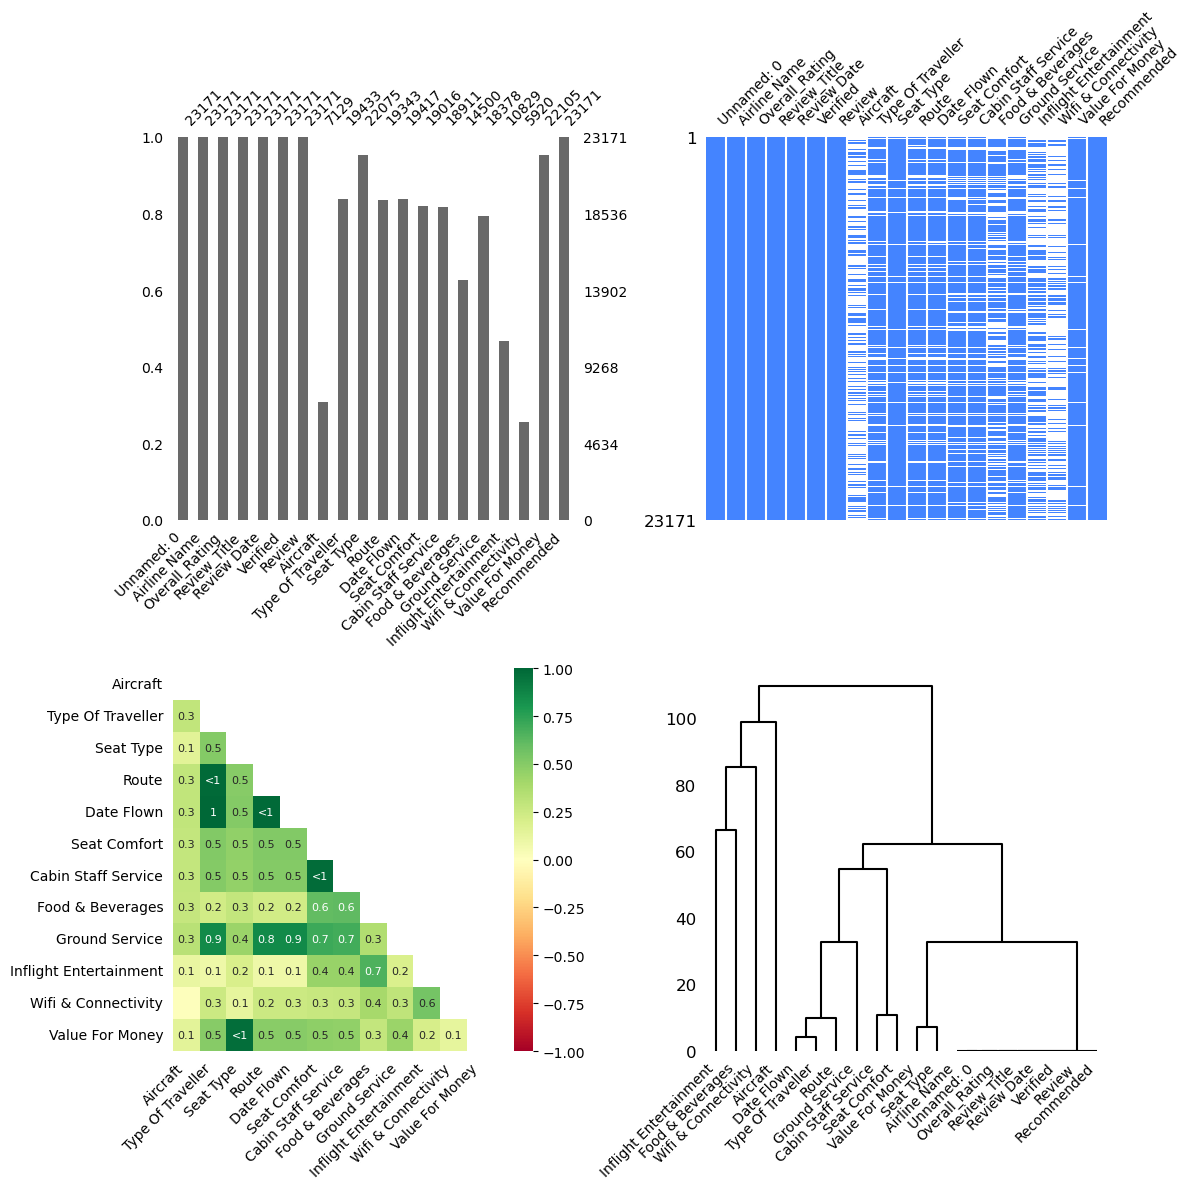

In [4]:
#Диаграмма, матрица, тепловая карта и дендограмма пропущенных значений на исходном наборе данных
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
msno.bar(airline,fontsize=10,figsize=(6,6),ax=ax1)
ax2 = fig.add_subplot(2,2,2)
msno.matrix(airline,fontsize=10,figsize=(6,6),color=(0.27, 0.52, 1.0),ax=ax2)
ax3 = fig.add_subplot(2,2,3)
msno.heatmap(airline,fontsize=10,figsize=(6,6),cmap="RdYlGn",ax=ax3)
ax4 = fig.add_subplot(2,2,4)
msno.dendrogram(airline,fontsize=10,figsize=(6,6),orientation="top",ax=ax4)

plt.tight_layout()

**Удаление ненужных признаков из набора данных, так как они не будут использованы в дальнешей работе**

In [6]:
columns_to_drop = ['Airline Name', 'Review_Title', 'Review Date' ,'Verified', 'Review', 'Aircraft', 'Route', 'Date Flown']# Удаление ненужных столбцов
data = airline.drop(columns=columns_to_drop)
data.head(5)

,Unnamed: 0,Overall_Rating,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,9,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,1,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,1,Solo Leisure,Economy Class,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,1,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [7]:
data.describe()

,Unnamed: 0,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,23171.00000,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,11585.00000,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,6689.03588,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5792.50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,11585.00000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,17377.50000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,23170.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
data.info() #количество ненулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Overall_Rating          23171 non-null  object 
 2   Type Of Traveller       19433 non-null  object 
 3   Seat Type               22075 non-null  object 
 4   Seat Comfort            19016 non-null  float64
 5   Cabin Staff Service     18911 non-null  float64
 6   Food & Beverages        14500 non-null  float64
 7   Ground Service          18378 non-null  float64
 8   Inflight Entertainment  10829 non-null  float64
 9   Wifi & Connectivity     5920 non-null   float64
 10  Value For Money         22105 non-null  float64
 11  Recommended             23171 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


In [9]:
data.describe(include=[object])

,Overall_Rating,Type Of Traveller,Seat Type,Recommended
count,23171,19433,22075,23171
unique,10,4,4,2
top,1,Solo Leisure,Economy Class,no
freq,11595,7120,19145,15364


In [10]:
data.describe(include=[float])

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


**В признаке "Общий рейтинг" исправим значение "n" на 10**

In [12]:
data['Overall_Rating'].unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

In [13]:
data['Overall_Rating']=data['Overall_Rating'].replace('n',10).astype(int)

In [14]:
data['Overall_Rating'].value_counts(normalize=True)

Overall_Rating
1     0.500410
2     0.099089
9     0.076302
8     0.075828
3     0.058521
7     0.051487
4     0.037072
10    0.036339
5     0.035821
6     0.029131
Name: proportion, dtype: float64

In [15]:
data['Type Of Traveller'].value_counts(normalize=True)

Type Of Traveller
Solo Leisure      0.366387
Couple Leisure    0.270931
Family Leisure    0.223949
Business          0.138733
Name: proportion, dtype: float64

In [16]:
data['Seat Type'].value_counts(normalize=True)

Seat Type
Economy Class      0.867271
Business Class     0.095040
Premium Economy    0.029264
First Class        0.008426
Name: proportion, dtype: float64

In [17]:
data['Recommended'].value_counts(normalize=True)

Recommended
no     0.66307
yes    0.33693
Name: proportion, dtype: float64

In [18]:
data['Seat Comfort'].value_counts(normalize=True)

Seat Comfort
1.0    0.333246
3.0    0.190261
4.0    0.177640
2.0    0.150873
5.0    0.140408
0.0    0.007573
Name: proportion, dtype: float64

In [19]:
data['Cabin Staff Service'].value_counts(normalize=True)

Cabin Staff Service
1.0    0.315742
5.0    0.246523
4.0    0.155465
3.0    0.150600
2.0    0.124795
0.0    0.006874
Name: proportion, dtype: float64

In [20]:
data['Food & Beverages'].value_counts(normalize=True)

Food & Beverages
1.0    0.364345
3.0    0.167172
4.0    0.160828
5.0    0.154621
2.0    0.135655
0.0    0.017379
Name: proportion, dtype: float64

In [21]:
data['Ground Service'].value_counts(normalize=True)

Ground Service
1.0    0.515453
5.0    0.171890
4.0    0.127707
3.0    0.098106
2.0    0.086843
Name: proportion, dtype: float64

In [22]:
data['Inflight Entertainment'].value_counts(normalize=True)

Inflight Entertainment
1.0    0.447410
3.0    0.156986
4.0    0.122726
2.0    0.118016
5.0    0.106750
0.0    0.048112
Name: proportion, dtype: float64

In [23]:
data['Wifi & Connectivity'].value_counts(normalize=True)

Wifi & Connectivity
1.0    0.685980
5.0    0.083108
3.0    0.082264
2.0    0.080912
4.0    0.067568
0.0    0.000169
Name: proportion, dtype: float64

In [24]:
data['Value For Money'].value_counts(normalize=True)

Value For Money
1.0    0.458539
5.0    0.172269
4.0    0.152861
2.0    0.110563
3.0    0.099570
0.0    0.006198
Name: proportion, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


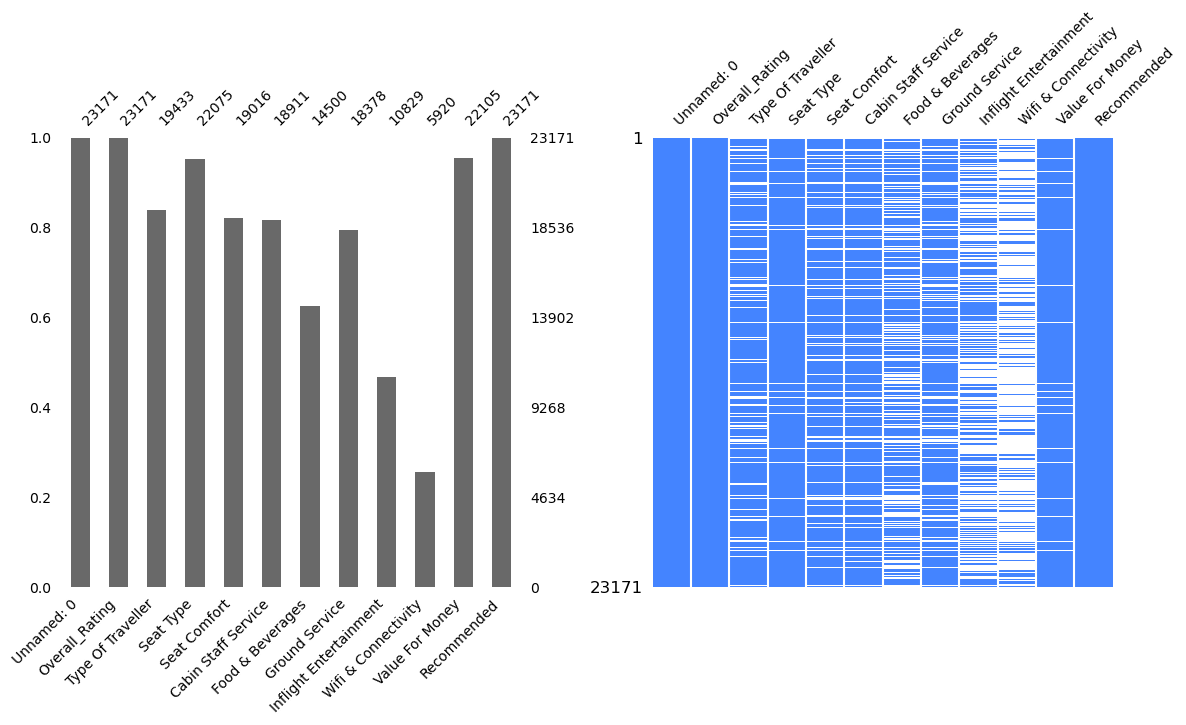

In [25]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(2,2,1)
msno.bar(data,fontsize=10,figsize=(6,6),ax=ax1)
ax2 = fig.add_subplot(2,2,2)
msno.matrix(data,fontsize=10,figsize=(6,6),color=(0.27, 0.52, 1.0),ax=ax2)

plt.tight_layout()

**Обработка пропущенных значений**

In [27]:
data.isnull().sum() #количество пропущенных зачений

Unnamed: 0                    0
Overall_Rating                0
Type Of Traveller          3738
Seat Type                  1096
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64

In [28]:
methods = {
    'Type Of Traveller': 'mode',
    'Seat Type': 'mode',
    'Seat Comfort': 'median',
    'Cabin Staff Service': 'mode',
    'Food & Beverages': 'mode',
    'Ground Service': 'mode',
    'Inflight Entertainment': 'mode',
    'Wifi & Connectivity': 'mode',
    'Value For Money': 'mode'
}

def fill_na(column):
    method = methods.get(column.name)
    if method == 'mean':
        return column.fillna(column.mean())
    elif method == 'mode':
        return column.fillna(column.mode()[0])
    elif method == 'median':
        return column.fillna(column.median())
    return column

data = data.apply(fill_na)
data.head(5)

,Unnamed: 0,Overall_Rating,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,9,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,1.0,1.0,3.0,yes
1,1,1,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,1.0,1.0,2.0,no
2,2,1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,1.0,1.0,2.0,no
3,3,1,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
4,4,1,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


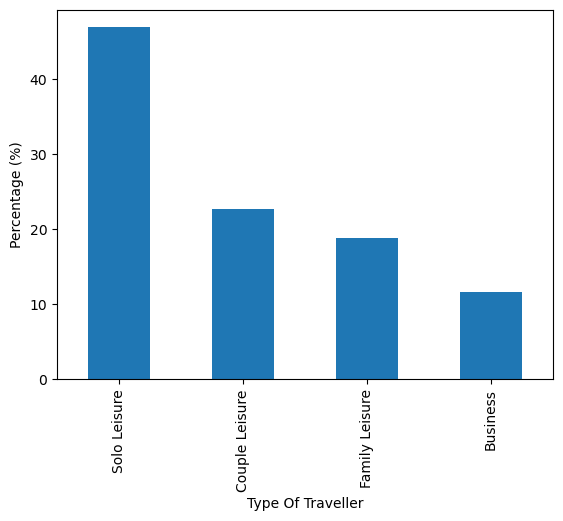

In [29]:
ax = data['Type Of Traveller'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

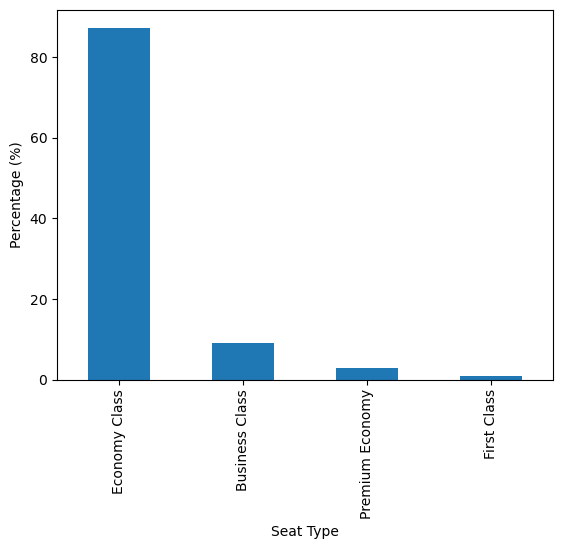

In [30]:
ax = data['Seat Type'].value_counts(normalize=True).mul(100).plot(kind='bar')
ax.set_ylabel('Percentage (%)')
plt.show()

Вопрос сбалансированности данных. Думаю, надо использовать другие методы заполнения пропущенных значений, чтобы категориальные даные были более сбалансированны.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Overall_Rating          23171 non-null  int32  
 2   Type Of Traveller       23171 non-null  object 
 3   Seat Type               23171 non-null  object 
 4   Seat Comfort            23171 non-null  float64
 5   Cabin Staff Service     23171 non-null  float64
 6   Food & Beverages        23171 non-null  float64
 7   Ground Service          23171 non-null  float64
 8   Inflight Entertainment  23171 non-null  float64
 9   Wifi & Connectivity     23171 non-null  float64
 10  Value For Money         23171 non-null  float64
 11  Recommended             23171 non-null  object 
dtypes: float64(7), int32(1), int64(1), object(3)
memory usage: 2.0+ MB


**Предварительный анализ данных**

Создаем новый признак с NPS каждого клиента, чтобы упростить расчет общего NPS. (NPS - это показатель, используемый для оценки лояльности и удовлетворенности клиентов в компании, который рассчитывается путем задания клиентам одного вопроса: “По шкале от 0 до 10, насколько вероятно, что вы порекомендуете этот продукт / компанию другу или коллеге?”)

In [35]:
def define_profile(score):
    if score <= 6:
        return 'Detractor'
    elif score <= 8:
        return 'Passive'
    else:
        return 'Promoter'

data['Profile'] = data['Overall_Rating'].apply(define_profile)
data.to_csv('../BKP_GIT/data/modified_file.csv', index=False)

**Расчет процентного соотношения категорий по "Типу места"**

In [37]:
profile_percentage = data.groupby(['Seat Type', 'Profile']).size() / data.groupby('Seat Type').size() * 100
profile_percentage = profile_percentage.unstack().fillna(0)

Определение цвета для каждой категории

In [39]:
colors = {'Promoter': 'green', 'Passive': 'yellow', 'Detractor': 'red'}

Построение столбчатой диаграммы. Отображение условных обозначений. Добавление меток с процентными значениями поверх столбцов.

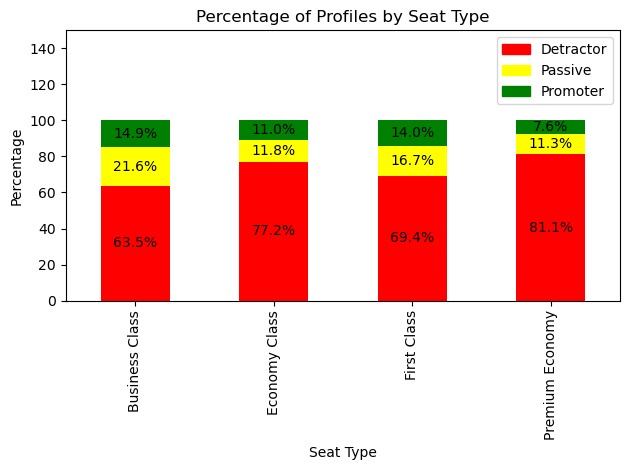

In [41]:
ax = profile_percentage.plot(kind='bar', stacked=True, color=[colors[col] for col in profile_percentage.columns])

plt.xlabel('Seat Type')
plt.ylabel('Percentage')
plt.title('Percentage of Profiles by Seat Type')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels], labels=labels)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

plt.ylim(0, 150)
plt.tight_layout()
plt.show()

Рекомендуют ли клиенты компанию, в зависимости от "Типа места"

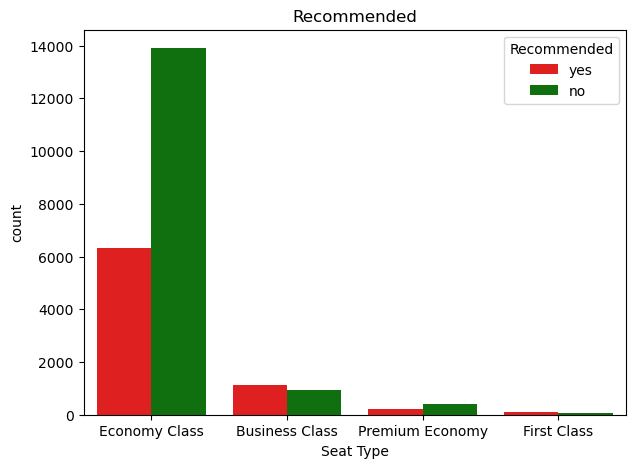

In [43]:
data.groupby(["Recommended","Seat Type"])["Recommended"].count()
fig, axs = plt.subplots(figsize=(7, 5))
axs = sns.countplot(x='Seat Type',hue='Recommended',data=data,palette=["red","green"]).set_title('Recommended')

Тест 3 моделей машинного обучения для этого набора данных - Случайный лес, XGBoost, LightGBM

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Overall_Rating          23171 non-null  int32  
 2   Type Of Traveller       23171 non-null  object 
 3   Seat Type               23171 non-null  object 
 4   Seat Comfort            23171 non-null  float64
 5   Cabin Staff Service     23171 non-null  float64
 6   Food & Beverages        23171 non-null  float64
 7   Ground Service          23171 non-null  float64
 8   Inflight Entertainment  23171 non-null  float64
 9   Wifi & Connectivity     23171 non-null  float64
 10  Value For Money         23171 non-null  float64
 11  Recommended             23171 non-null  object 
 12  Profile                 23171 non-null  object 
dtypes: float64(7), int32(1), int64(1), object(4)
memory usage: 2.2+ MB


In [46]:
data['Recommended'] = data['Recommended'].map({'yes': 1, 'no': 0})

In [47]:
x = data[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Inflight Entertainment',
          'Wifi & Connectivity', 'Value For Money']]  # Признаки
y = data['Recommended']                               # Целевая переменная

In [48]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.30)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10670
           1       0.92      0.90      0.91      5550

    accuracy                           0.94     16220
   macro avg       0.93      0.93      0.93     16220
weighted avg       0.94      0.94      0.94     16220



Text(0.5, 1.0, 'Accuracy Score 0.94')

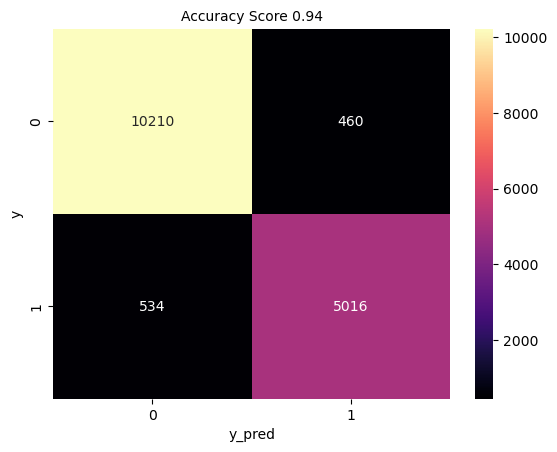

In [49]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

y_pred = rf_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10671
           1       0.92      0.91      0.91      5549

    accuracy                           0.94     16220
   macro avg       0.94      0.93      0.93     16220
weighted avg       0.94      0.94      0.94     16220



Text(0.5, 1.0, 'Accuracy Score 0.94')

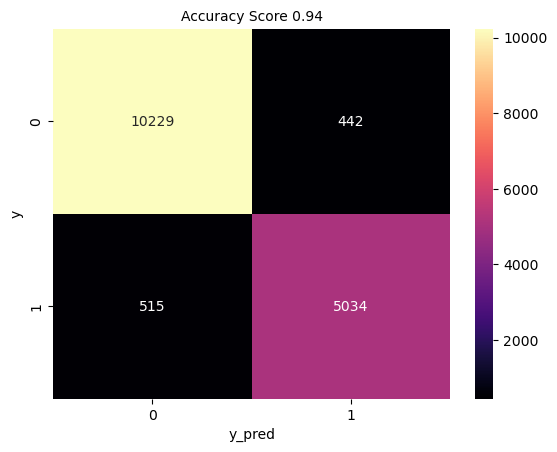

In [50]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train,y_train)

y_pred = xgboost_model.predict(x_test)
accuracy_score(y_pred,y_test)

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))

sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10645
           1       0.93      0.91      0.92      5575

    accuracy                           0.94     16220
   macro avg       0.94      0.94      0.94     16220
weighted avg       0.94      0.94      0.94     16220



Text(0.5, 1.0, 'Accuracy Score 0.94')

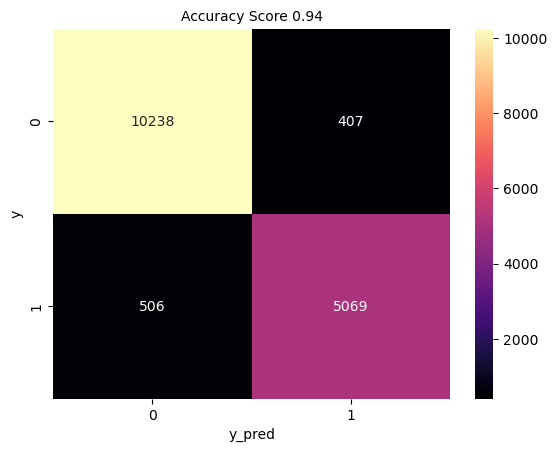

In [51]:
# LightGBM

lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(x_train,y_train)

y_pred = lgb_model.predict(x_test)
accuracy_score(y_pred,y_test) # 0.963

cm = confusion_matrix(y_pred,y_test)
acc = round(accuracy_score(y_pred,y_test),2)

print(classification_report(y_pred,y_test))


sns.heatmap(cm,annot=True, fmt=".0f",cmap = 'magma')
plt.xlabel("y_pred")
plt.ylabel("y")
plt.title(f"Accuracy Score {acc}",size=10)

**Оптимизация моделей**

In [53]:
# RandomForestClassifier

rf_model = RandomForestClassifier()
rf_params = {"max_depth":[5,8],
             "max_features":[4,8,"auto"],
             "min_samples_split":[2,5,8],
             "n_estimators":[100,200,500]}

rf_best_grid = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
rf_best_grid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packages

{'max_depth': 8,
 'max_features': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

In [54]:
rf_final = RandomForestClassifier().set_params(**rf_best_grid.best_params_).fit(x_train,y_train)
y_pred = rf_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.94
Precision: 0.92
Recall:    0.91
F1 score:  0.92
ROC:       0.94


In [55]:
# XGBoost
xgboost_model = XGBClassifier()
xgboost_params = {"max_depth":[5,6],
             "learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]}

xgboost_best_grid = GridSearchCV(xgboost_model,xgboost_params,cv=5,n_jobs=-1,verbose=True).fit(x_train,y_train)
xgboost_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 500}

In [56]:
xgboost_final = XGBClassifier().set_params(**xgboost_best_grid.best_params_).fit(x_train,y_train)
y_pred = xgboost_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.95
Precision: 0.93
Recall:    0.91
F1 score:  0.92
ROC:       0.94


In [57]:
# LightGBM
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgbm_params = {"learning_rate":[0.1,0.01],
             "colsample_bytree":[0.7,1],
             "n_estimators":[100,200,500]
               }

lgbm_best_grid = GridSearchCV(lgb_model,lgbm_params,cv=5,n_jobs=-1,verbose=0).fit(x_train,y_train)
lgbm_best_grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}

In [58]:
lgbm_final = lgb.LGBMClassifier(verbose=-1).set_params(**lgbm_best_grid.best_params_).fit(x,y)
y_pred = lgbm_final.predict(x_test)

print(f"Accuracy:  {(accuracy_score(y_pred, y_test)):.2f}\nPrecision: \
{(precision_score(y_pred, y_test)):.2f}\nRecall:    \
{(recall_score(y_pred, y_test)):.2f}\nF1 score:  \
{(f1_score(y_pred, y_test)):.2f}\nROC:       \
{(roc_auc_score(y_pred, y_test)):.2f}")

Accuracy:  0.95
Precision: 0.93
Recall:    0.93
F1 score:  0.93
ROC:       0.95


**Важность признаков**

In [60]:
rf_feature_imp = pd.DataFrame({"Value":rf_final.feature_importances_, "Feature":x_train.columns})
xgb_feature_imp = pd.DataFrame({"Value":xgboost_final.feature_importances_, "Feature":x_train.columns})
lgb_feature_imp = pd.DataFrame({"Value":lgbm_final.feature_importances_, "Feature":x_train.columns})

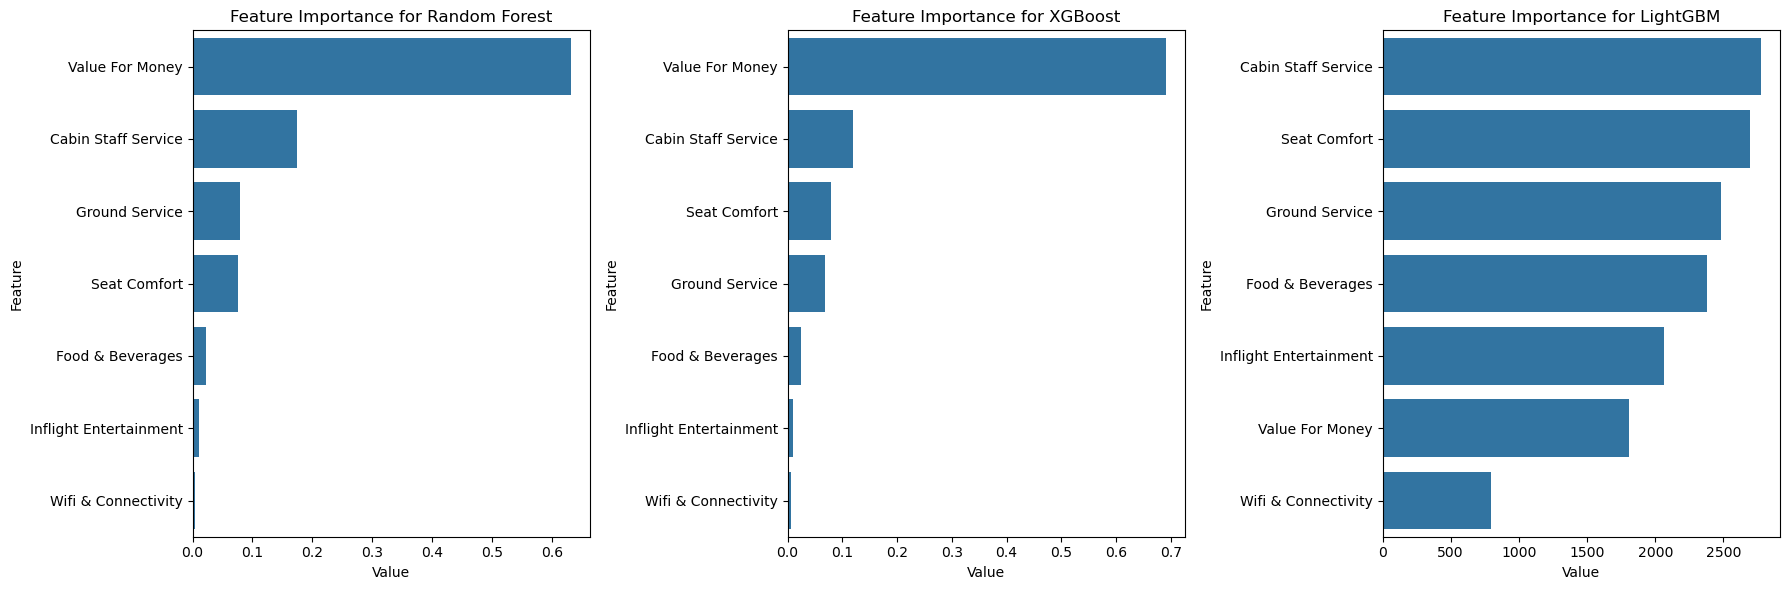

In [61]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

sns.barplot(x="Value",y="Feature",data=rf_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[0])
axs[0].set_title('Feature Importance for Random Forest')
sns.barplot(x="Value",y="Feature",data=xgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[1])
axs[1].set_title('Feature Importance for XGBoost')
sns.barplot(x="Value",y="Feature",data=lgb_feature_imp.sort_values(by="Value",ascending=False)[0:len(x_train)],ax=axs[2])
axs[2].set_title('Feature Importance for LightGBM')
plt.tight_layout()

In [62]:
classifiers = [("RandomForestClassifier",RandomForestClassifier(),RandomForestClassifier(max_depth= 8,max_features=8,min_samples_split= 5,n_estimators=100)),
               ("XGBClassifier",XGBClassifier(),XGBClassifier(colsample_bytree= 0.7,learning_rate=0.1,max_depth= 5,n_estimators=100)),
               ("LGBMClassifier",lgb.LGBMClassifier(verbose=-1),lgb.LGBMClassifier(colsample_bytree= 0.7,learning_rate=0.1,n_estimators=100,verbose=-1))]

In [63]:
def calculate(y):
    acc = accuracy_score(y,y_test)
    pre = precision_score(y,y_test)
    rec = recall_score(y,y_test)
    f1 = f1_score(y,y_test)
    auc = roc_auc_score(y,y_test)
    return acc,pre,rec,f1,auc

In [64]:
def model_call(x_train, x_test, y_train, y_test,mod_opt,plot=False):

    pl= []
    i = 0
    if mod_opt == False:
        for name,mod1,mod2 in classifiers:

            model = mod1.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred)
            pl.append([acc,pre,rec,f1,auc])

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]} Precision: {pl[i][1]} Recall: {pl[i][2]} F1 score: {pl[i][3]} ROC:{pl[i][4]}\n")
            i = i + 1
    pl2 = []
    if mod_opt:

        for name,mod1,mod2 in classifiers:
            model = mod1.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred)
            pl.append([acc,pre,rec,f1,auc])

            final = mod2.fit(x_train,y_train)
            y_pred_final = final.predict(x_test)
            acc,pre,rec,f1,auc = calculate(y_pred_final)
            pl2.append([acc,pre,rec,f1,auc])

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]:.3f} Precision: {pl[i][1]:.3f} Recall: {pl[i][2]:.3f} F1 score: {pl[i][3]:.3f} ROC:{pl[i][4]:.3f}\nAfter:  Accuracy: {pl2[i][0]:.3f} Precision: {pl2[i][1]:.3f} Recall: {pl2[i][2]:.3f} F1 score: {pl2[i][3]:.3f} ROC:{pl2[i][4]:.3f}\n")

            print(f"{name.upper()}\nBefore: Accuracy: {pl[i][0]:.2f} Precision: {pl[i][1]:.2f} Recall: {pl[i][2]:.2f} F1 score: {pl[i][3]:.2f} ROC:{pl[i][4]:.2f}\nAfter:  Accuracy: {pl2[i][0]:.2f} Precision: {pl2[i][1]:.2f} Recall: {pl2[i][2]:.2f} F1 score: {pl2[i][3]:.2f} ROC:{pl2[i][4]:.2f}\n")

            i = i + 1

    if plot:
        plot_importance(model, x_train)
        plot_importance(final, x_train)


model_call(x_train, x_test, y_train, y_test,mod_opt=True)

RANDOMFORESTCLASSIFIER
Before: Accuracy: 0.939 Precision: 0.918 Recall: 0.904 F1 score: 0.911 ROC:0.931
After:  Accuracy: 0.943 Precision: 0.923 Recall: 0.909 F1 score: 0.916 ROC:0.935

RANDOMFORESTCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.92 Recall: 0.90 F1 score: 0.91 ROC:0.93
After:  Accuracy: 0.94 Precision: 0.92 Recall: 0.91 F1 score: 0.92 ROC:0.93

XGBCLASSIFIER
Before: Accuracy: 0.941 Precision: 0.919 Recall: 0.907 F1 score: 0.913 ROC:0.933
After:  Accuracy: 0.946 Precision: 0.929 Recall: 0.913 F1 score: 0.921 ROC:0.938

XGBCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.92 Recall: 0.91 F1 score: 0.91 ROC:0.93
After:  Accuracy: 0.95 Precision: 0.93 Recall: 0.91 F1 score: 0.92 ROC:0.94

LGBMCLASSIFIER
Before: Accuracy: 0.944 Precision: 0.926 Recall: 0.909 F1 score: 0.917 ROC:0.936
After:  Accuracy: 0.945 Precision: 0.929 Recall: 0.910 F1 score: 0.920 ROC:0.937

LGBMCLASSIFIER
Before: Accuracy: 0.94 Precision: 0.93 Recall: 0.91 F1 score: 0.92 ROC:0.94
After:  Accuracy: 0.95 Pr

In [69]:
lgbm_final.booster_.save_model('../BKP_GIT/model/lgbm_model.txt')#сохраняем модель
loaded_model = lgb.Booster(model_file = '../BKP_GIT/model/lgbm_model.txt')